In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"arekkaus","key":"84e109c35e2f5ad28ebf8068464d7f24"}'}

In [ ]:
mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
  Using cached kaggle-1.5.6-py3-none-any.whl


In [ ]:
!kaggle competitions download -c rfcx-species-audio-detection -p /content/drive/My\ Drive/kaggle/rainforest2 --force

100% 49.7G/49.7G [14:33<00:00, 48.1MB/s]
100% 49.7G/49.7G [14:34<00:00, 61.0MB/s]


In [ ]:
import os
os.chdir('/content/drive/My Drive/kaggle/rainforest2')  #change dir
!mkdir train  #create a directory named train/
!mkdir test  #create a directory named test/

!unzip /content/drive/MyDrive/kaggle/rainforest2/rfcx-species-audio-detection.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: test/e416a5eca.flac     
  inflating: test/e41b84fa7.flac     
  inflating: test/e45e758c1.flac     
  inflating: test/e4cb4370c.flac     
  inflating: test/e5078d068.flac     
  inflating: test/e50f9f241.flac     
  inflating: test/e512b33fb.flac     
  inflating: test/e52fe0b41.flac     
  inflating: test/e539e1a4d.flac     
  inflating: test/e53ef2a35.flac     
  inflating: test/e56187b03.flac     
  inflating: test/e56fb8264.flac     
  inflating: test/e57475890.flac     
  inflating: test/e5848e7db.flac     
  inflating: test/e5880f75c.flac     
  inflating: test/e5b87fda5.flac     
  inflating: test/e5ed0271d.flac     
  inflating: test/e6353d64a.flac     
  inflating: test/e68644d1e.flac     
  inflating: test/e6cb26296.flac     
  inflating: test/e751d4faa.flac     
  inflating: test/e7acab4ef.flac     
  inflating: test/e80456d8d.flac     
  inflating: test/e81a06c38.flac     
  inflating: test/e82c2

In [ ]:
for i in range(24):
  os.mkdir(f'/content/drive/MyDrive/kaggle/rainforest2/train_melspectrograms/s{str(i)}')

In [ ]:
%pip install noisereduce

In [ ]:
!ls /content/drive/MyDrive/kaggle/rainforest2/

rfcx-species-audio-detection.zip  tfrecords	train_melspectrograms
sample_submission.csv		  train		train_tp.csv
test				  train_fp.csv


In [ ]:
import os
import shutil
import pathlib
import multiprocessing as mp
from shutil import copyfile
import IPython
from PIL import Image
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import librosa
import librosa.display
import soundfile as sf
import noisereduce as nr
import keras
from keras import layers
from keras import models
from keras import preprocessing
from keras import applications

/usr/local/lib/python3.6/dist-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


In [ ]:
#Spectral gating noise removal

def denoise(audio_data, sampling_rate, t_min):
    noise_interval = [0, int(sampling_rate * t_min)]
    noisy_part = audio_data[noise_interval[0]:noise_interval[1]]
    denoised_audio = nr.reduce_noise(audio_clip=audio_data, noise_clip=noisy_part)
    
    return denoised_audio

In [ ]:
#Butterworth bandpass filter

def bandpass_filter(audio_data, sampling_rate, f_min, f_max):
    bandpass_filter = signal.butter(4, (0.9*f_min, 1.1*f_max), 'bandpass', fs=sampling_rate, output='sos')
    filtered_audio = signal.sosfilt(bandpass_filter, audio_data)
    
    return filtered_audio

In [ ]:
train_tp = pd.read_csv('/content/drive/MyDrive/kaggle/rainforest2/train_tp.csv')
train_tp

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
...,...,...,...,...,...,...,...
1211,fe8d9ac40,13,1,53.4720,93.750,54.0960,843.75
1212,fea6b438a,4,1,43.5787,2531.250,45.7653,4031.25
1213,ff2eb9ce5,0,1,15.2267,5906.250,16.0213,8250.00
1214,ffb8d8391,5,1,14.3467,4781.250,16.6987,10406.20


In [ ]:
#Longest signal

for idx, row in train_tp.iterrows():
  max_len = 0
  len = row['t_max'] - row['t_min']

  if len > max_len:
    max_len = len
  
print(max_len)

0.6933000000000007


In [ ]:
#Slice training data (cut silence)

def slice_train_audio(audio_data, sampling_rate, t_min, t_max, slice_len):
    slice_center = (t_max*sampling_rate + t_min*sampling_rate) / 2
    slice_start = (slice_center-slice_len) / 2

    if slice_start < 0:
        slice_start = 0

    slice_end = (slice_center+slice_len) / 2

    if slice_end < (60 * sampling_rate):
        slice_end = 60 * sampling_rate

    return audio_data[int(slice_start):int(slice_end)]

In [ ]:
#Generate melspectrograms of cleaned training true positive audio data

def train_data_gen(a=None, b=None):
    sampling_rate = 48000
    max_freq = 14000
    slice_len = 5 * sampling_rate

    for idx, row in train_tp.iloc[a:b].iterrows():
        recording_id = row['recording_id']
        t_max = row['t_max']
        t_min = row['t_min']
        f_min = row['f_min']
        f_max = row['f_max']
        label = row['species_id']
        train_dir = '/content/drive/MyDrive/kaggle/rainforest2/train'
        train_spects_dir = '/content/drive/MyDrive/kaggle/rainforest2/train_melspectrograms'
        
        #Read file
        filename = f'{recording_id}.flac'
        path = f'{train_dir}/{filename}'
        
        audio_data, sampling_rate = librosa.load(path, sr=sampling_rate)
        
        #Clean audio
        #denoised_audio = denoise(audio_data, sampling_rate, t_min)
        filtered_audio = bandpass_filter(audio_data, sampling_rate, f_min, f_max)
        audio_slice = slice_train_audio(filtered_audio, sampling_rate, t_min, t_max, slice_len)
        
        #Generate melspectrograms
        spectrogram = librosa.feature.melspectrogram(y=audio_slice, sr=sampling_rate, fmax=max_freq)
        spectrogram = librosa.power_to_db(spectrogram)
        img = librosa.display.specshow(spectrogram, sr=sampling_rate)
        plt.savefig(f'{train_spects_dir}/s{str(label)}/{recording_id}.jpg')
        
        print(f'{idx} spectrograms generated')

In [ ]:
#Generate melspectrograms of test audio data

def test_data_gen(a=None, b=None, name='gen0'):
    sampling_rate = 48000
    f_max = 13700
    f_min = 93
    slice_len = 5 * sampling_rate
    n_slices = 12
    test_dir = '/content/drive/MyDrive/kaggle/rainforest2/test'
    test_spects_dir = '/content/drive/MyDrive/kaggle/rainforest2/test_melspectrograms'

    for j, filename in enumerate(os.listdir(test_dir)[a:b]):
        #Create folder
        if os.path.exists(f'{test_spects_dir}/{filename[:-5]}'):
            shutil.rmtree(f'{test_spects_dir}/{filename[:-5]}')

        os.mkdir(f'{test_spects_dir}/{filename[:-5]}')
        
        #Read audio file
        audio_data, sampling_rate = librosa.load(f'{test_dir}/{filename}', sr=sampling_rate)
        
        #Clean audio
        filtered_audio = bandpass_filter(audio_data, sampling_rate, f_min, f_max)
        
        #Slice audio and generate melspectrograms
        for i in range(n_slices):
            audio_slice = audio_data[i*slice_len:(i+1)*slice_len]
            spectrogram = librosa.feature.melspectrogram(y=audio_slice, sr=sampling_rate, fmax=14000)
            spectrogram = librosa.power_to_db(spectrogram)
            img = librosa.display.specshow(spectrogram, sr=sampling_rate)
            plt.savefig(f'{test_spects_dir}/{filename[:-5]}/{i}.jpg')
        
        print(f'{name} {j+1} spectrograms generated')

In [ ]:
p1 = mp.Process(target=test_data_gen, args=(1968, 1971, 'gen1933'))
p2 = mp.Process(target=test_data_gen, args=(1970, 1975, 'gen1939'))

p1.start()
p2.start()

p1.join()
p2.join()

gen1933 1 spectrograms generated
gen1939 1 spectrograms generated
gen1933 2 spectrograms generated
gen1939 2 spectrograms generated
gen1933 3 spectrograms generated
gen1939 3 spectrograms generated
gen1939 4 spectrograms generated
gen1939 5 spectrograms generated


In [ ]:
def test_data_gen_fill(filename):
    sampling_rate = 48000
    f_max = 13700
    f_min = 93
    slice_len = 5 * sampling_rate
    n_slices = 12
    test_dir = '/content/drive/MyDrive/kaggle/rainforest2/test'
    test_spects_dir = '/content/drive/MyDrive/kaggle/rainforest2/test_melspectrograms'
    #filename = '5d6a40fcc'
    #Create folder
    if os.path.exists(f'{test_spects_dir}/{filename}'):
        shutil.rmtree(f'{test_spects_dir}/{filename}')

    os.mkdir(f'{test_spects_dir}/{filename}')
        
    #Read audio file
    audio_data, sampling_rate = librosa.load(f'{test_dir}/{filename}.flac', sr=sampling_rate)
        
    #Clean audio
    filtered_audio = bandpass_filter(audio_data, sampling_rate, f_min, f_max)
        
    #Slice audio and generate melspectrograms
    for i in range(n_slices):
        audio_slice = audio_data[i*slice_len:(i+1)*slice_len]
        spectrogram = librosa.feature.melspectrogram(y=audio_slice, sr=sampling_rate, fmax=14000)
        spectrogram = librosa.power_to_db(spectrogram)
        img = librosa.display.specshow(spectrogram, sr=sampling_rate)
        plt.savefig(f'{test_spects_dir}/{filename}/{i}.jpg')
        
        print(f'{i+1} spectrograms generated')

In [ ]:
image_size = (432, 288)
n_channels = 3
n_labels = 24
n_epochs = 20

In [ ]:
#Read cleaned train dataset

train_dir = '/content/drive/MyDrive/kaggle/rainforest2/train_melspectrograms/'

train_ds = preprocessing.image_dataset_from_directory(train_dir, image_size=image_size, labels='inferred', label_mode='categorical', validation_split=0.2, subset='training', seed=14)
validation_ds = preprocessing.image_dataset_from_directory(train_dir, image_size=image_size, labels='inferred', label_mode='categorical', validation_split=0.2, subset='validation', seed=14)

Found 1161 files belonging to 24 classes.
Using 929 files for training.
Found 1161 files belonging to 24 classes.
Using 232 files for validation.


In [ ]:
train_ds

<BatchDataset shapes: ((None, 432, 288, 3), (None, 24)), types: (tf.float32, tf.float32)>

In [ ]:
resnet_base = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], n_channels))

In [ ]:
#Model

model = models.Sequential()

#model.add(keras.Input(shape=(image_size[0], image_size[1], n_channels)))
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255))

model.add(resnet_base)
model.add(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Flatten())
model.add(layers.BatchNormalization())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(n_labels, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
resnet_base.trainable = False

In [ ]:
#Model

model = models.Sequential()

model.add(layers.experimental.preprocessing.Rescaling(scale=1./255))
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(image_size[0], image_size[1], n_channels), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.2))

#model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
#model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(n_labels, activation='relu'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
training_history = model.fit(train_ds, epochs=20, batch_size=32, validation_data=validation_ds)

Epoch 1/20
10/30 [=========>....................] - ETA: 7s - loss: 704793.7967 - accuracy: 0.0683

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/kaggle/rainforest2/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kaggle/rainforest2/assets


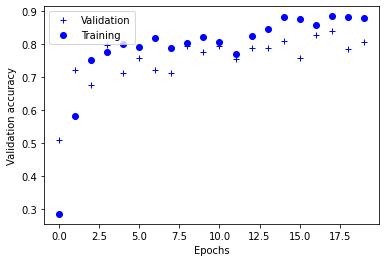

In [ ]:
epochs = range(0, n_epochs)
train_accuracy = training_history.history['accuracy']
val_accuracy= training_history.history['val_accuracy']

plt.plot(epochs, val_accuracy, 'b+', label='Validation')
plt.plot(epochs, train_accuracy, 'bo', label='Training')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.show()

# Test data

In [ ]:
#Predict

y_pred = pd.DataFrame()
test_dir = '/content/drive/MyDrive/kaggle/rainforest2/test_melspectrograms/'
subdirs = [x[0] for x in os.walk(test_dir)]

for i, subdir in enumerate(subdirs[1:]):
    recording_id = subdir[63:]
    files = os.walk(subdir).__next__()[2]
    max_values = np.zeros(24)

    for file in files:
        img = Image.open(f'{subdir}/{file}')
        data = np.asarray(img)
        data = np.swapaxes(data, 0, 1)
        data = data[np.newaxis, ...]
        pred = model(data).numpy()
        
        if max_values[np.argmax(pred)] < pred[0,np.argmax(pred)]:
            max_values[np.argmax(pred)] = pred[0,np.argmax(pred)]

    row = pd.DataFrame({'recording_id' : [recording_id], 
                        's0' : [max_values[0]], 's1' : [max_values[1]],
                        's2' : [max_values[2]], 's3' : [max_values[3]],
                        's4' : [max_values[4]], 's5' : [max_values[5]],
                        's6' : [max_values[6]], 's7' : [max_values[7]],
                        's8' : [max_values[8]], 's9' : [max_values[9]],
                        's10' : [max_values[10]], 's11' : [max_values[11]],
                        's12' : [max_values[12]], 's13' : [max_values[13]],
                        's14' : [max_values[14]], 's15' : [max_values[15]],
                        's16' : [max_values[16]], 's17' : [max_values[17]],
                        's18' : [max_values[18]], 's19' : [max_values[19]],
                        's20' : [max_values[20]], 's21' : [max_values[21]],
                        's22' : [max_values[22]], 's23' : [max_values[23]]})
    
    print(data.shape)
    print(f'{i} predicted')
    y_pred = y_pred.append(row, ignore_index=True)
    
print(y_pred)

(1, 432, 288, 3)
0 predicted
(1, 432, 288, 3)
1 predicted
(1, 432, 288, 3)
2 predicted
(1, 432, 288, 3)
3 predicted


KeyboardInterrupt: ignored

In [ ]:
y_pred.to_csv(path_or_buf='/content/drive/MyDrive/kaggle/rainforest2/y_pred2.csv', index=False)